In [1]:
import numpy as np
import bilby
import matplotlib.pyplot as plt
%matplotlib inline

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

outdir = 'outdir_InectionStudyTaylorF2Ecc'
label = 'EccentricFD_InectionStudyTaylorF2Ecc'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.
np.random.seed(150914)

In [44]:
mass_1 = 3.0
mass_2 = 1.1
chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
mass_ratio = mass_2/mass_1
ff = (C**3)/( G*(mass_1+mass_2)*Mo*np.pi*6**(3/2) )
tot_m = chirp_mass*(1+mass_ratio)**(6/5)/mass_ratio**(3/5)
print(chirp_mass,mass_ratio)
print(ff)
print(tot_m)

1.5436597935229655 0.3666666666666667
1072.198789497317
4.1


In [ ]:
chirp_mass_ = 2.611651689888372
mass_ratio_ =  1.

mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
print("mass_1 = {}, mass_2 = {}".format(mass_1_, mass_2_))

In [36]:
time_of_event = 1126259642.413
post_trigger_duration = 1.0
duration = 3.0
analysis_start = time_of_event + post_trigger_duration - duration
sampling_frequency = 64.

In [39]:
# frequency_array, mass_1, mass_2, luminosity_distance, a_1, a_2, theta_jn, phase
injection_parameters = dict(
    mass_1=1.1, mass_2=1.1, eccentricity=0.0656632, luminosity_distance=20.0, a_1=0., a_2=0., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

waveform_arguments = dict(waveform_approximant='TaylorF2Ecc',
                          reference_frequency=15., minimum_frequency=15., catch_waveform_errors=True)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_taylorF2Ecc_fd,
    waveform_arguments=waveform_arguments)

10:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_taylorF2Ecc_fd
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [42]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
for ifo in ifos:
    ifo.minimum_frequency = 25.0
    ifo.maximum_frequency = 256.0

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=analysis_start)

ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

10:45 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'


ValueError: The injected signal has a duration in-band of 145.7s, but the data for detector H1 has a duration of 3.0s

04:05 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'
04:05 bilby INFO    : Injected signal in H1:
04:05 bilby INFO    :   optimal SNR = 32.23
04:05 bilby INFO    :   matched filter SNR = 98.47+0.63j
04:05 bilby INFO    :   mass_1 = 1.5
04:05 bilby INFO    :   mass_2 = 1.5
04:05 bilby INFO    :   eccentricity = 0.0656632
04:05 bilby INFO    :   luminosity_distance = 20.0
04:05 bilby INFO    :   a_1 = 0.0
04:05 bilby INFO    :   a_2 = 0.0
04:05 bilby INFO    :   theta_jn = 0.4
04:05 bilby INFO    :   psi = 2.659
04:05 bilby INFO    :   phase = 1.3
04:05 bilby INFO    :   geocent_time = 1126259642.413
04:05 bilby INFO    :   ra = 1.375
04:05 bilby INFO    :   dec = -1.2108
04:05 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'
04:05 bilby INFO    : Injected signal in L1:
04:05 bilby INFO    :   optimal SNR = 26.10
04:05 bilby INFO    :   matched filter SNR = 77.56-0.02j
04:05 bilby INFO    :   mass_1 = 1.5
04:05 bilby INFO    :   mas

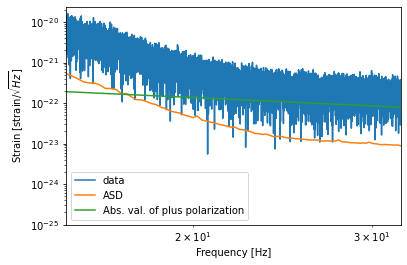

In [19]:
#to plot the frequency domain  
injection = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")

'''L1 = ifos[1]
L1_injection = injection[1]

ax.loglog(L1.frequency_array[idxs]+5,
          L1.amplitude_spectral_density_array[idxs],
          label="ASD")'''

ax.set_xlim(15.,32.)
ax.set_ylim(1e-25,2.327737159425905e-20)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [18]:
snrs = [ifo.meta_data["optimal_SNR"] for ifo in ifos]
np.sqrt(np.sum([i ** 2 for i in snrs]))

41.47023325353553

In [23]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = bilby.gw.prior.Uniform(name='chirp_mass', minimum=0.8705505632961241,maximum=2.611651689888372)
prior['mass_ratio'] = bilby.gw.prior.Uniform(name='mass_ratio', minimum=0.3333333333333333, maximum=1)
prior['eccentricity'] = bilby.gw.prior.Uniform(name='e0', minimum=0.0, maximum=0.1)
prior["luminosity_distance"] = 20.0
prior["theta_jn"] = 0.4
prior["a_1"] = 0.0
prior["a_2"] = 0.0
prior["psi"] = 2.659
prior["phase"] = 1.3
prior["geocent_time"] = 1126259642.413
prior["ra"] = 1.375
prior["dec"] = -1.2108
    
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator, priors=prior)

In [24]:
result_short = bilby.core.sampler.run_sampler(
    likelihood, prior, sampler='dynesty', outdir=outdir, label=label,
    nlive=500, dlogz=3.0, npool=8 )

04:11 bilby INFO    : Running for label 'EccentricFD_InectionStudyTaylorF2Ecc', output will be saved to 'outdir_InectionStudyTaylorF2Ecc'
04:11 bilby INFO    : Using lal version 7.1.7.1
04:11 bilby INFO    : Using lal git version Branch: master;Tag: None;Id: 7eef7079ec7a112132bd11eb292c5535d2ebf6b2;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
04:11 bilby INFO    : Using lalsimulation version 3.1.2.1
04:11 bilby INFO    : Using lalsimulation git version Branch: master;Tag: None;Id: 7eef7079ec7a112132bd11eb292c5535d2ebf6b2;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
04:11 bilby INFO    : Search parameters:
04:11 bilby INFO    :   chirp_mass = Uniform(minimum=0.8705505632961241, maximum=2.611651689888372, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
04:11 bilby INFO    :   mass_ratio = Uniform(minimum=0.3333333333333333, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
04

0it [00:00, ?it/s]

04:11 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 8, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f1c9fb2b0d0>>, 'dlogz': 3.0, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
04:11 bilby INFO    : Checkpoint every check_point_delta_t = 600s
04:11 bilby INFO    : Using dynesty version 1.0.1
04:11 bilby INFO    : Using the bil

2411it [10:13,  1.95s/it, bound:449 nc:296 ncall:2.2e+05 eff:1.1% logz-ratio=-436.99+/-0.16 dlogz:3530.144>3]

04:21 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflo

3007it [20:18,  2.55s/it, bound:997 nc:495 ncall:4.7e+05 eff:0.6% logz-ratio=-413.21+/-0.18 dlogz:4346.038>3]

04:31 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
04:31 bilby WARNING : singular matrix
04:31 bilby WARNING : Failed to create dynesty state plot at checkpoint
04:31 bilby WARNING : singular matrix
04:31 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
04:31 bilby WARNING : singular matrix
04:31 bilby WARNING : Failed to create dynesty run plot at checkpoint


3573it [30:28,  1.29s/it, bound:1570 nc:  1 ncall:7.4e+05 eff:0.5% logz-ratio=-366.89+/-0.22 dlogz:4575.284>3] 

04:41 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflo

4228it [40:31,  1.59s/it, bound:2182 nc:401 ncall:1.0e+06 eff:0.4% logz-ratio=874.76+/-0.25 dlogz:3397.016>3] 

04:52 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
04:52 bilby WARNING : singular matrix
04:52 bilby WARNING : Failed to create dynesty state plot at checkpoint
04:52 bilby WARNING : singular matrix
04:52 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
04:52 bilby WARNING : singular matrix
04:52 bilby WARNING : Failed to create dynesty run plot at checkpoint


4846it [50:42,  2.45s/it, bound:2783 nc:453 ncall:1.3e+06 eff:0.4% logz-ratio=2475.73+/-0.25 dlogz:1811.956>3]

05:02 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
05:02 bilby WARNING : singular matrix
05:02 bilby WARNING : Failed to create dynesty state plot at checkpoint
05:02 bilby WARNING : singular matrix
05:02 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
05:02 bilby WARNING : singular matrix
05:02 bilby WARNING : Failed to create dynesty run plot at checkpoint


5406it [1:00:45,  1.85s/it, bound:3344 nc:495 ncall:1.5e+06 eff:0.4% logz-ratio=3117.23+/-0.25 dlogz:1191.965>3]

05:12 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
05:12 bilby WARNING : singular matrix
05:12 bilby WARNING : Failed to create dynesty state plot at checkpoint
05:12 bilby WARNING : singular matrix
05:12 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
05:12 bilby WARNING : singular matrix
05:12 bilby WARNING : Failed to create dynesty run plot at checkpoint


5956it [1:10:56,  1.37s/it, bound:3897 nc:500 ncall:1.8e+06 eff:0.3% logz-ratio=3603.22+/-0.26 dlogz:708.897>3] 

05:22 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
05:22 bilby WARNING : Axis limits cannot be NaN or Inf
05:22 bilby WARNING : Failed to create dynesty run plot at checkpoint


6500it [1:21:09,  1.38s/it, bound:4449 nc:440 ncall:2.1e+06 eff:0.3% logz-ratio=3901.13+/-0.26 dlogz:418.118>3]

05:32 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
05:32 bilby WARNING : Axis limits cannot be NaN or Inf
05:32 bilby WARNING : Failed to create dynesty run plot at checkpoint


7047it [1:31:20,  2.52s/it, bound:4999 nc:495 ncall:2.3e+06 eff:0.3% logz-ratio=4098.26+/-0.27 dlogz:222.520>3]

05:42 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
05:42 bilby WARNING : Axis limits cannot be NaN or Inf
05:42 bilby WARNING : Failed to create dynesty run plot at checkpoint


7594it [1:41:29,  1.78s/it, bound:5551 nc:474 ncall:2.6e+06 eff:0.3% logz-ratio=4203.08+/-0.27 dlogz:118.976>3]

05:53 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
05:53 bilby WARNING : Axis limits cannot be NaN or Inf
05:53 bilby WARNING : Failed to create dynesty run plot at checkpoint


8160it [1:51:39,  1.49s/it, bound:6132 nc:379 ncall:2.9e+06 eff:0.3% logz-ratio=4260.04+/-0.28 dlogz:61.469>3] 

06:03 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
06:03 bilby WARNING : Axis limits cannot be NaN or Inf
06:03 bilby WARNING : Failed to create dynesty run plot at checkpoint


8770it [2:01:45,  1.00s/it, bound:6751 nc:  1 ncall:3.2e+06 eff:0.3% logz-ratio=4306.04+/-0.28 dlogz:13.831>3]

06:13 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
06:13 bilby WARNING : Axis limits cannot be NaN or Inf
06:13 bilby WARNING : Failed to create dynesty run plot at checkpoint


9394it [2:12:00,  1.95it/s, bound:7380 nc:  1 ncall:3.5e+06 eff:0.3% logz-ratio=4317.12+/-0.32 dlogz:0.016>3] 

06:23 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
06:23 bilby WARNING : Axis limits cannot be NaN or Inf
06:23 bilby WARNING : Failed to create dynesty run plot at checkpoint


9938it [2:20:34,  1.17it/s, bound:7928 nc:493 ncall:3.7e+06 eff:0.3% logz-ratio=4315.16+/-0.28 dlogz:3.004>3]

06:32 bilby INFO    : Written checkpoint file outdir_InectionStudyTaylorF2Ecc/EccentricFD_InectionStudyTaylorF2Ecc_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/lal2/lib/python3.10/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
06:32 bilby WARNING : Axis limits cannot be NaN or Inf
06:32 bilby WARNING : Failed to create dynesty run plot at checkpoint
06:32 bilby INFO    : Starting to close worker pool.
06:32 bilby INFO    : Finished closing worker pool.


9938it [2:20:45,  1.18it/s, bound:7928 nc:  1 ncall:3.7e+06 eff:0.3% logz-ratio=4317.12+/-0.30 dlogz:0.005>3]



06:32 bilby INFO    : Sampling time: 2:20:24.258758
06:32 bilby INFO    : Summary of results:
nsamples: 10438
ln_noise_evidence: -25411.248
ln_evidence: -21094.130 +/-  0.299
ln_bayes_factor: 4317.118 +/-  0.299

